#### Note: 1번 DiscreteREINFORCE에서 겹치는 변수나 함수는 설명이 기재되어있지 않습니다.
#### 따라서 설명이 있는 부분만 보시면, 1번과의 차이점을 확인하실 수 있습니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

import gym
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# for using sampling with gradient-tracking when selecting an action
# Discrete action과는 달리, Normal 함수를 활용하는 것을 보실 수 있습니다 (Categorical은 불연속 확률 변수에 대해서 정의되어지는 확률 분포이기 때문).
# 이름에서 짐작하실 수 있듯이, gaussian 확률 분포입니다.
from torch.distributions import Normal

In [2]:
class Policy(nn.Module):

    def __init__(self, input_dim, action_dim, hidden):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden)
        self.mean = nn.Linear(hidden, action_dim) # Discrete 과의 차이점. 각 action의 mean, std를 구한다.
        self.mean_scale = 1 # 일반적으로 초기 학습의 안정성을 위해서 mean값의 상한과 하한을 정하는데, 예를 들어 tanh를 쓰면 -1~1로 정할 수 있습니다. 이러한 상한, 하한의 scaling을 위한 변수. 
        self.std = nn.Linear(hidden, action_dim) 
        
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        mean = torch.tanh(self.mean(out)) * self.mean_scale # 평균값 상한과 하한을 위해 tanh를 적용하였습니다.
        std = torch.exp(self.std(out)) # sutton책 chapter.13의 13.7에 exponential을 쓰는 이유가 나와있습니다 (양수로 만들기 위함 + 좀 더 나은 approximate 성능). 
        return mean, std

In [3]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, input_dim, action_dim, hidden, learning_rate, device, save_mode, model_name, saving_start_epi):
        # environment parameter
        self.gamma = gamma
        self.env = env
        self.input_dim = input_dim
        self.action_dim = action_dim

        # trainig parameter
        self.device = device
        self.n_epi = n_epi
        self.max_steps = max_steps
        self.plot_freq = plot_freq
        self.frame_cnt = 0

        # network paramter
        self.lr = learning_rate
        self.policy = Policy(self.input_dim, self.action_dim, hidden).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)
        
        # log parameter
        self.avg = []
        self.scores = []
        self.losses = []
        self.save_mode = save_mode
        self.model_name = model_name
        self.saving_start = saving_start_epi
        
    def select_action(self, state):
        """
            Discrete action space일 때 뽑는 것과 달리, policy net에서 구한 mean, std를 이용하여 Gaussian 분포를 생성한 후(Normal 함수),
            그 함수에서 action을 sampling 합니다. 그런데 이렇게 sampling하면, 예를 들어 mean값이 -1~1로 정해졌다 할지라도 
            gaussian 분포에서 뽑는 것이기 때문에 절대값이 매우 큰 양수 or 음수가 action으로 뽑힐 수 있습니다.
            그러므로 이렇게 뽑힌 action을 다시 한번 상한과 하한을 정할 수 있는데요,
            다만, 이때 주의할 것이 미분가능을 염두하여야 하므로, torch.clamp를 일반적으로 활용합니다.
            예) torch.clamp(tensor, min=-1.0, max=1.0)
        """
        mean, std = self.policy(torch.FloatTensor(state).view(1, -1).to(self.device)) 
        nor_dist = Normal(mean, std) 
        action = torch.clamp(nor_dist.sample(), min=-2.0, max=2.0) 
        
        # [0]을 넣은 이유: nor_dist.sample()의 차원이 (1, 2)라서 0차원을 없애기 위해서. .unsqueeze()를 활용해도 됩니다.
        return action.detach().cpu().numpy()[0], nor_dist.log_prob(action)[0].sum(), mean.detach().cpu().numpy(), std.detach().cpu().numpy()
    
    def train(self):
        
        for i_episode in range(1, self.n_epi+1):
            epi_history = []
            rewards = [] 
            score = 0

            state = self.env.reset() 
            for step in range(self.max_steps):
                action, log_prob, mean, std = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                
                epi_history.append([log_prob, reward])
                state = next_state
                score += reward
                self.frame_cnt += 1
                if done: break
            self.scores.append(score)
            loss = self._update_policy(epi_history)
            self.losses.append(loss)
            if i_episode%self.plot_freq == 0:
                self._plot_status(i_episode, self.losses, self.scores)
                
            if self.save_mode & (i_episode > self.saving_start): self._save_model()
            self.avg.append(np.mean(self.scores[-10:]))

    def test(self, model_path):
        ''' 저장된 pt파일을 불러와 test 합니다 '''
        
        self.policy.load_state_dict(torch.load(model_path))
        self.policy.eval()
        
        state = self.env.reset()
        done = False
        score = 0
        accum_frames = []
        while not done:
            accum_frames.append(self.env.render(mode="rgb_array"))
            action, log_prob, prob  = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return accum_frames
    
    def _update_policy(self, epi_history):
        accum_R = 0
        loss = 0
        epi_len = len(epi_history) - 1 

        for idx, [log_p, r] in enumerate(epi_history[::-1]):
            accum_R = r + (self.gamma*accum_R)
            gamma_pow_t = self.gamma**(epi_len-idx)
            one_step_loss = -log_p * gamma_pow_t * accum_R
            loss += one_step_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def _save_model(self):
        last_mean = np.mean(self.scores[-11:-1])
        if max(self.avg) < last_mean:
            torch.save(self.policy.state_dict(), self.model_name+f'Score_{round(last_mean, 3)}.pt')

    def _plot_status(self, i_episode, losses, scores):
        subplot_params = [
            (121, f"Scores in episode_{i_episode}", scores),
            (122, f"Policy loss in episode_{i_episode}", losses),
        ]

        clear_output(True)
        plt.figure(figsize=(10, 5), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show()
        

In [ ]:
device = torch.device(
            "cuda:1" if torch.cuda.is_available() else "cpu"
        )
env_list = ["Pendulum-v0", "MountainCarContinuous-v0", "LunarLanderContinuous-v2"]
env_name = env_list[0]

# 몇 episode 이후부터 저장할 것인지 정하는 변수 입니다.
saving_start_epi = 100

# model을 저장할 폴더를 지정합니다. 기본은 저장하지 않는 mode 입니다.
save_mode = True
model_save_folder = './model_save'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
model_name = f"./{model_save_folder}/Continuous_REINFORCE_{env_name}_"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

n_epi = 100000 
max_steps = 500
gamma = 0.95
plot_freq = 10
hidden = 64
learning_rate = 0.0005

In [5]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            learning_rate,
            device,
            save_mode,
            model_name,
            saving_start_epi)

In [ ]:
### Continous action space의 경우는 learning rate 등의 hyper parameter에 더욱 민감한 것 같습니다. 학습이 잘 안되는 경우가 생각보다 많았습니다.

agent.train() 

In [ ]:
# 모델을 test하고 게임 플레이한 결과를 배열로 저장합니다.

model_path = f"./{model_save_folder}/Discrete_REINFORCE_CartPole-v0_Score_200.0.pt"
frames = agent.test(model_path)

# 위의 배열로 저장한 것을 test.mp4 파일을 만들고 재생합니다. 
# 배열을 재생시키는 방법은 여러가지가 있습니다. 만일, 

import imageio
from IPython.display import Video
imageio.mimwrite('./test.mp4', frames, fps=30)
Video('./test.mp4', width=480, height=360)

    LunarLander 환경
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.999
    plot_freq = 10
    hidden = 64
    learning_rate = 0.0008

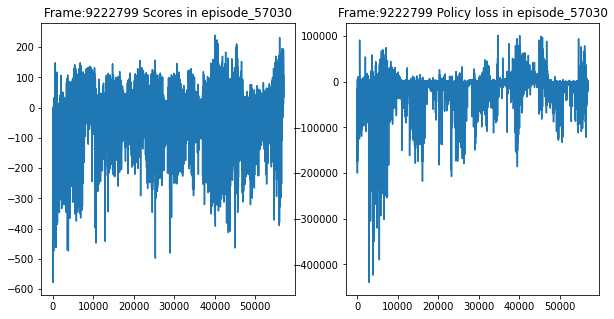

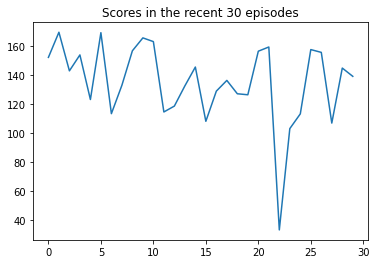

    LunarLander 환경
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.95
    plot_freq = 10
    hidden = 128
    learning_rate = 0.00075

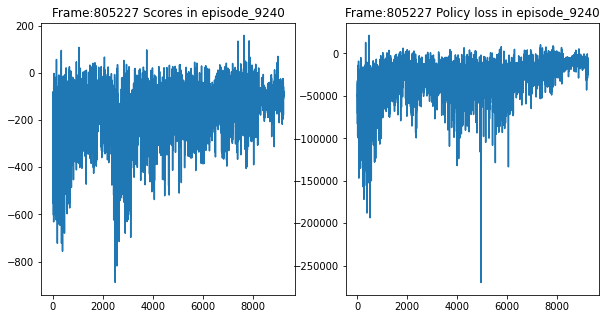

    LunarLander 환경
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.95
    plot_freq = 10
    hidden = 128
    learning_rate = 0.002

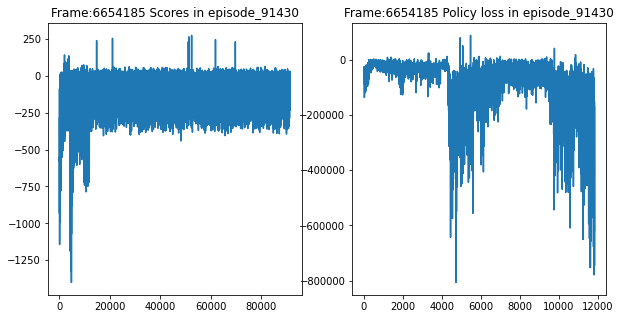

    LunarLander 환경
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.95
    plot_freq = 10
    hidden = 64
    learning_rate = 0.006

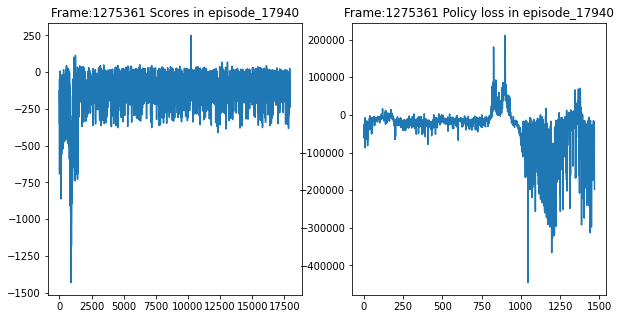